<a href="https://colab.research.google.com/github/Tomawock/MLDM_COVID-19/blob/master/Dtr_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-DIVIDIAMO

## CREAZIONE DI MODELLI basati su DT

Questo notebook ha lo scopo di addestrare alcuni **modelli** di predizione per il nostro dataset basati su **Alberi di Decisione (DT)**. Per farlo, utilizzeremo nuovamente la procedura automatizzata tramite **grid search**.

In [89]:
%autosave 30
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 8)

import joblib
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import r2_score, mean_squared_error, max_error

from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os



Autosaving every 30 seconds
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### MODELLO: preparazione dei datasets

**Carichiamo** il dataset ed impostiamo il **random state**. Trasformiamo l'attributo nominale in numerico.

**Dividiamo** il dataset in:
* **training** set
* **testing** set

Proviamo utilizzando l'**80%** dei records per il training set ed il restante per il testing.

In [90]:
df = pd.read_csv("/content/drive/Shared drives/MLDM progetto/Datasets/dataset_finale_medie.csv")
rnd_state = 27
predictor_columns = [ 'pass_Altezza Neve', 'pass_Ammoniaca', 'pass_Benzene',
       'pass_Biossido di Azoto', 'pass_Biossido di Zolfo', 'pass_BlackCarbon',
       'pass_Direzione Vento', 'pass_Livello Idrometrico',
       'pass_Monossido di Azoto', 'pass_Monossido di Carbonio',
       'pass_Ossidi di Azoto', 'pass_Ozono', 'pass_PM10 (SM2005)',
       'pass_Particelle sospese PM2.5', 'pass_Precipitazione',
       'pass_Radiazione Globale', 'pass_Temperatura', 'pass_Umidità Relativa',
       'pass_Velocità Vento', 'pass_deceduti', 'pass_dimessi_guariti',
       'pass_isolamento_domiciliare', 'pass_nuovi_positivi',
       'pass_ricoverati_con_sintomi', 'pass_tamponi', 'pass_terapia_intensiva',
       'pass_totale_casi', 'pass_totale_ospedalizzati', 'pass_totale_positivi',
       'pass_variazione_totale_positivi']

**Prepariamo** il **training** set ed il **test** set.

In [91]:
train = df.sample(frac=0.8, random_state=rnd_state)
test = df.drop(train.index)

train_X = train[predictor_columns]
train_y = train["fut1_nuovi_positivi"]

test_X = test[predictor_columns]
test_y = test["fut1_nuovi_positivi"]


### MODELLO: training ###

Creiamo il **regressore** basato su alberi di decisione.

In [92]:
dt_regressor = DecisionTreeRegressor(random_state=rnd_state)

Definiamo la **Pipeline**, come abbiamo fatto per le ANN:
* imputer
* addestramento del modello

In [93]:
pipeline = Pipeline([("imp", SimpleImputer(missing_values=np.nan, strategy="mean")), 
                     ("dtr", dt_regressor)])

Prepariamo gli **iper-parametri** per la grid search.

In [94]:
criterion_list = ["mse", "mae", "friedman_mse"]
splitter_list = ["best", "random"]
max_depth_list = [None, 5, 6]
min_samples_split_list = [2, 3]
min_samples_split_leaf_list = [1, 2]
min_weight_fraction_leaf_list = [0.0, 0.1]
max_features_list = [None, "sqrt", "auto"]
max_leaf_nodes_list = [None, 10, 25]
min_impurity_decrease_list = [0.0, 0.1]

param_grid = {"dtr__criterion": criterion_list,
              "dtr__splitter": splitter_list,
              "dtr__max_depth": max_depth_list,
              "dtr__min_samples_split": min_samples_split_list,
              "dtr__min_samples_leaf": min_samples_split_leaf_list,
              "dtr__min_weight_fraction_leaf": min_weight_fraction_leaf_list,
              "dtr__max_features": max_features_list,
              "dtr__max_leaf_nodes": max_leaf_nodes_list,
              "dtr__min_impurity_decrease": min_impurity_decrease_list}

**Addestriamo** il regressore mediante **grid search** e **k-fold** cross validation. Anche questa volta, utilizziamo k non superiore a 5 in modo da avere degli insiemi statisticamente significativi (con almeno 30 elementi).

In [95]:
kfold_splits = 5
grid_regressor = GridSearchCV(estimator=pipeline,  
                              n_jobs=-1, 
                              verbose=1,
                              return_train_score=True,
                              cv=KFold(n_splits=kfold_splits, shuffle=True),
                              param_grid=param_grid)

grid_regressor.fit(train_X, train_y)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2760 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 6760 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 12360 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 12960 out of 12960 | elapsed:  1.4min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('dtr',
                                        DecisionTreeRegressor(ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                         

### MODELLO: testing ###

Processiamo i dati di test allo stesso modo del training e procediamo alla fase di testing del **miglior regressore**, addestrato mediante grid search.

In [96]:
best_regressor = grid_regressor.best_estimator_["dtr"]

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer = imputer.fit(test_X)
test_X_imp = imputer.transform(test_X)

predicted = best_regressor.predict(test_X_imp)

In [97]:
#print(list(test_X.index))
x_triks=df.loc[list(test_X.index),['Data']]#prende gli indici dei dati di test e va nel csv originario e prende le date corrispondenti
#print(x_triks.values)

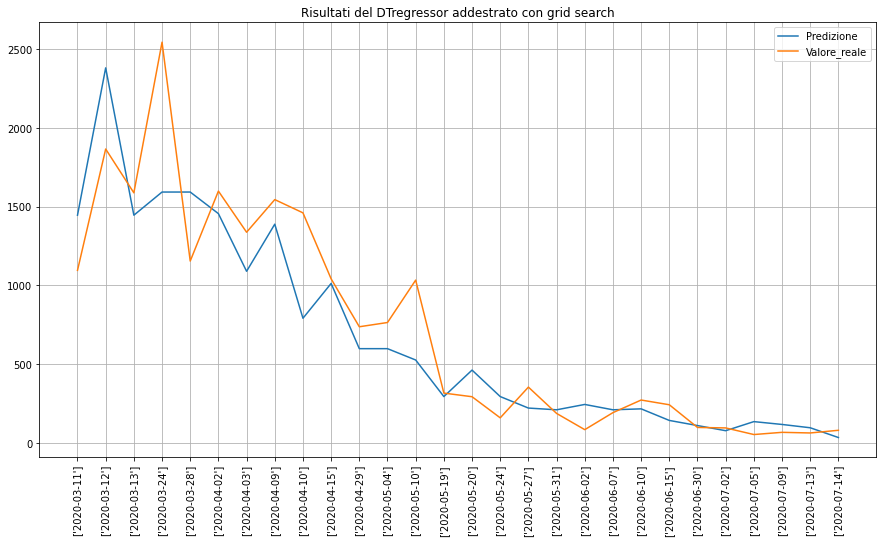

In [104]:
plt.plot(predicted, label="Predizione")
plt.plot(test_y.values, label="Valore_reale")
plt. xticks(np.arange(x_triks.shape[0]), (x_triks.values), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati del DTregressor addestrato con grid search")
plt.show()

### MODELLO: valutazione ed osservazioni ###

Vediamo le **caratteristiche** del miglior albero di decisione trovato.

In [99]:
best_regressor

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.1, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=27, splitter='best')

Si tratta di un DecisionTreeRegressor con splitter **random** e criterio di split **MAE** (Mean Absolute Error)

Calcoliamo alcune **misure di performance** per il regressore basato su alberi di decisione. Abbiamo scelto quelle a parer nostro più significative:
* **R2**: coefficiente di determinazione
* **RMSE**: root mean squared error
* **MAX Error**: errore massimo

In [100]:
print(f"R2: \t\t{r2_score(test_y, predicted):.3}")
print(f"RMSE: \t\t{mean_squared_error(test_y, predicted, squared=False):.3}")
print(f"MAX ERR: \t{max_error(test_y, predicted)}")

R2: 		0.809
RMSE: 		2.98e+02
MAX ERR: 	951.0


Possiamo **osservare** che le performance del miglior albero di decisione trovato sono abbastanza **buone**.

**R2** è **0.893**, ampiamente superiore a 0.5 ed abbastanza vicino al massimo (1). Questo vuol dire che il modello spiega gran parte della varianza dei dati.

**RMSE** è **59.7**, pertanto il nostro modello in media sbaglia il conteggio dei nuovi positivi di 60 unità. Seppur di primo acchitto sembri eccessivo, in realtà non lo è se si pensa che in alcune giornate sono stati registrati più di 1000 nuovi positivi.

**MAX ERR** è **238**. Dal grafico si nota come in un preciso giorno il predittore sbagli parecchio. Questo errore molto pronunciato va ad influenzare negativamente l'RMSE.

### MODELLO: feature importance

Visualizziamo la **feature importance** derivante dal training del miglior albero regressore.

In [101]:
feature_importance = dict(zip(predictor_columns, best_regressor.feature_importances_))
feature_importance

{'pass_Altezza Neve': 0.7367652222210401,
 'pass_Ammoniaca': 0.0007010078322598305,
 'pass_Benzene': 0.00024476947267162015,
 'pass_Biossido di Azoto': 0.00010892993620378773,
 'pass_Biossido di Zolfo': 0.005987570939950094,
 'pass_BlackCarbon': 0.0003036601668451532,
 'pass_Direzione Vento': 0.006478664564451623,
 'pass_Livello Idrometrico': 0.009332617558191633,
 'pass_Monossido di Azoto': 0.0006984429165646453,
 'pass_Monossido di Carbonio': 4.6592805552236614e-05,
 'pass_Ossidi di Azoto': 0.0005724430155379127,
 'pass_Ozono': 0.11545603203865255,
 'pass_PM10 (SM2005)': 1.0529107659660878e-06,
 'pass_Particelle sospese PM2.5': 0.00013461815113131304,
 'pass_Precipitazione': 0.04590818736656356,
 'pass_Radiazione Globale': 0.0004820631609316746,
 'pass_Temperatura': 0.00014821649367376065,
 'pass_Umidità Relativa': 0.015948791658482134,
 'pass_Velocità Vento': 0.003781128429702561,
 'pass_deceduti': 0.0003542417994877177,
 'pass_dimessi_guariti': 0.00010955641810953738,
 'pass_isolam

La feature più importante per lo split è stata, senza sorpresa, **"nuovi_positivi_mean"**, ossia la media dei nuovi positivi nei 5 giorni precedenti rispetto al giorno di riferimento.

La vera sorpresa è stata la feature **"so2"**, al secondo posto per importanza, con grande distacco da tutte le altre. L'anidride solforosa sembra avere una **correlazione importante** con i nuovi positivi predetti.

Un'ultima osservazione interessante riguarda l'attributo **"region"**, che è quello meno importante di tutti. Ciò vuol dire che, con buona probabilità, il modello si comporterà bene anche con **altre zone geografiche**.

### Salvataggio e caricamento del modello ###

Scriviamo due **funzioni** ad hoc per il salvataggio ed il caricamento di modelli sci-kit learn.

In [102]:
def save_scikit_model(kind, model):
    folder = "models/" + kind + "-" + datetime.now().strftime("%d-%m-%Y %Hh%M")
    os.mkdir(folder)
    joblib.dump(model, folder + "/" + "model.joblib")
    
def load_scikit_model(folder):
    loaded_model = joblib.load(folder + "/model.joblib")
    return loaded_model

**Salviamo** il modello migliore trovato.

In [103]:
save_scikit_model("DTR-grid", best_regressor)

FileNotFoundError: ignored

**Carichiamo** il modello appena salvato per verificare che non ci siano stati errori nel salvataggio.

In [ ]:
loaded_model = load_scikit_model("models/DTR-grid-08-07-2020 15h27")

loaded_predicted = loaded_model.predict(test_X_imp)